PROJECT_ROOT   : /home/edgelab/oscar/stream-active-FL
ANNOTATIONS_DIR: /home/edgelab/oscar/stream-active-FL/data/annotations_original_imgs
DATASET_ROOT   : /mnt/ZOD_clone_2018_scaleout_zenseact


Loading infos: 1473it [00:02, 633.19it/s]


Found 1459 annotated sequences.
Selected sequence index 50: seq_id=000050
Frames in sequence      : 201
Total detections        : 1952
Showing image_id=0 (has detections)
frame_idx=0


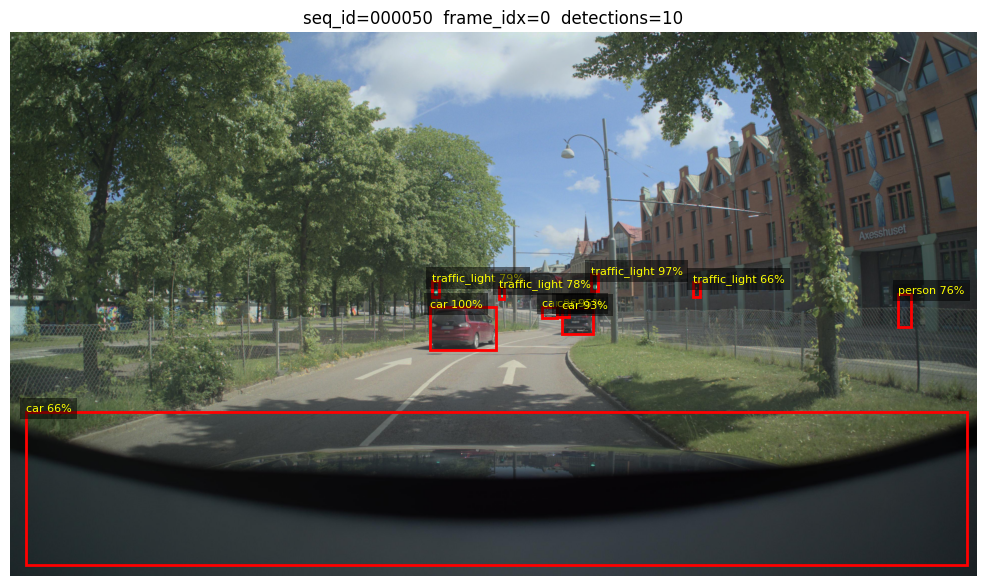

In [8]:
"""
Visual check of Detectron2 pseudo-label annotations on ZOD sequences.

This notebook loads a per-sequence annotation JSON and displays bounding boxes
overlaid on the corresponding image frames loaded via ZodSequences.

Two modes are supported:
  - Cell 1: Show a single frame (first frame with detections, or fallback to frame 0).
  - Cell 2: Show multiple consecutive frames from the same sequence.

To switch between original (high-res) and cropped (256x256) data, change:
  - ANNOTATIONS_DIR: annotations_original_imgs vs annotations_ZODCropped
  - DATASET_ROOT: /mnt/ZOD_clone_2018_scaleout_zenseact vs 
                  /mnt/pr_2018_scaleout_workdir/ZODCropped
"""

from pathlib import Path
import json

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

from zod import ZodSequences

# =============================================================================
# Configuration: paths and which sequence to visualize
# =============================================================================

PROJECT_ROOT = Path("/home/edgelab/oscar/stream-active-FL").resolve()

# Cropped images
#ANNOTATIONS_DIR = PROJECT_ROOT / "data" / "annotations_ZODCropped"
#DATASET_ROOT = Path("/mnt/pr_2018_scaleout_workdir/ZODCropped/")

# Original images
ANNOTATIONS_DIR = PROJECT_ROOT / "data" / "annotations_original_imgs"
DATASET_ROOT = Path("/mnt/ZOD_clone_2018_scaleout_zenseact/")

VERSION = "full"  # ZOD version: "full" or "mini"

# Which sequence (by sorted index) to visualize
SEQ_INDEX = 50

# =============================================================================
# Validation and dataset loading
# =============================================================================

print(f"PROJECT_ROOT   : {PROJECT_ROOT}")
print(f"ANNOTATIONS_DIR: {ANNOTATIONS_DIR}")
print(f"DATASET_ROOT   : {DATASET_ROOT}")

assert ANNOTATIONS_DIR.is_dir(), f"Annotations dir not found: {ANNOTATIONS_DIR}"
assert DATASET_ROOT.is_dir(), f"ZOD dataset_root not found: {DATASET_ROOT}"

zod_sequences = ZodSequences(dataset_root=str(DATASET_ROOT), version=VERSION)

# =============================================================================
# Load annotation JSON for the selected sequence
# =============================================================================

json_paths = sorted(ANNOTATIONS_DIR.glob("*.json"))
assert json_paths, f"No JSON files found in {ANNOTATIONS_DIR}"
print(f"Found {len(json_paths)} annotated sequences.")

assert 0 <= SEQ_INDEX < len(json_paths), (
    f"SEQ_INDEX {SEQ_INDEX} out of range (0..{len(json_paths)-1})"
)

seq_path = json_paths[SEQ_INDEX]
seq_id = seq_path.stem  # e.g. "000002"
print(f"Selected sequence index {SEQ_INDEX}: seq_id={seq_id}")

with seq_path.open("r") as f:
    ann_data = json.load(f)

# images: list of {id, file_name, frame_idx, width, height}
# annotations: list of {id, image_id, frame_idx, category_id, bbox, score, area, ...}
images = ann_data.get("images", [])
annotations = ann_data.get("annotations", [])

# Build lookup tables
images_by_id = {img["id"]: img for img in images}
anns_by_image = {}  # image_id -> list of annotation dicts
for ann in annotations:
    anns_by_image.setdefault(ann["image_id"], []).append(ann)

print(f"Frames in sequence      : {len(images)}")
print(f"Total detections        : {len(annotations)}")

# =============================================================================
# Pick one frame to display (prefer one that has detections)
# =============================================================================

image_ids_with_anns = [img_id for img_id, anns in anns_by_image.items() if anns]
if image_ids_with_anns:
    image_id = min(image_ids_with_anns)  # lowest image_id with detections
    print(f"Showing image_id={image_id} (has detections)")
else:
    image_id = min(images_by_id.keys())
    print(f"No detections in sequence; showing image_id={image_id}")

img_meta = images_by_id[image_id]
frame_idx = img_meta["frame_idx"]
print(f"frame_idx={frame_idx}")

# =============================================================================
# Load the frame via ZodSequences and display with bounding boxes
# =============================================================================

sequence = zod_sequences[seq_id]
frames = sequence.info.get_camera_frames()  # front camera frames
frame = frames[frame_idx]

img_np = frame.read()  # numpy array (H, W, 3)
img = Image.fromarray(img_np)

# Category ID -> human-readable name (matches annotate.py mapping)
CATEGORY_NAMES = {0: "person", 1: "car", 2: "traffic_light"}

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img)

# Overlay bounding boxes for this frame
for ann in anns_by_image.get(image_id, []):
    x, y, w, h = ann["bbox"]  # COCO format: top-left (x, y) + width, height
    rect = Rectangle((x, y), w, h, linewidth=2, edgecolor="red", facecolor="none")
    ax.add_patch(rect)

    # Label: "car 85%", "person 92%", etc.
    cat_id = ann.get("category_id", -1)
    score = float(ann.get("score", 0.0))
    cat_name = CATEGORY_NAMES.get(cat_id, str(cat_id))
    label = f"{cat_name} {score * 100:.0f}%"
    ax.text(
        x, y, label,
        color="yellow", fontsize=8,
        bbox=dict(facecolor="black", alpha=0.5, linewidth=0),
    )

n_boxes = len(anns_by_image.get(image_id, []))
ax.set_title(f"seq_id={seq_id}  frame_idx={frame_idx}  detections={n_boxes}")
ax.axis("off")
plt.tight_layout()
plt.show()

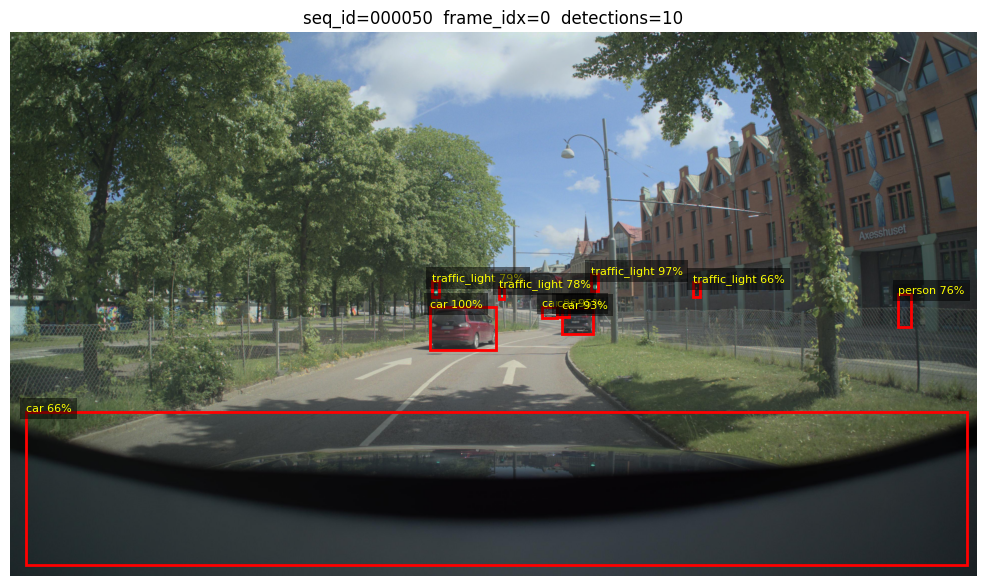

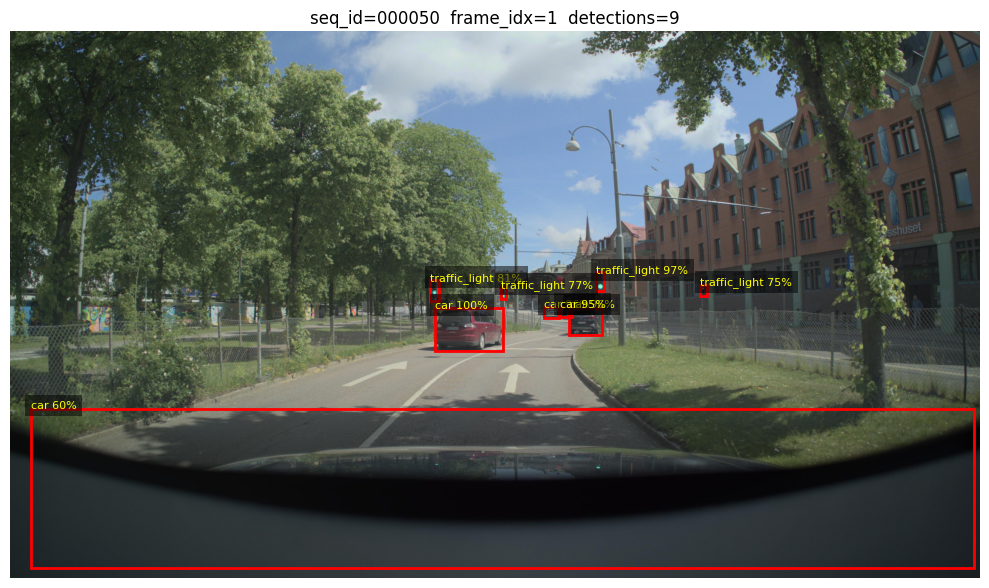

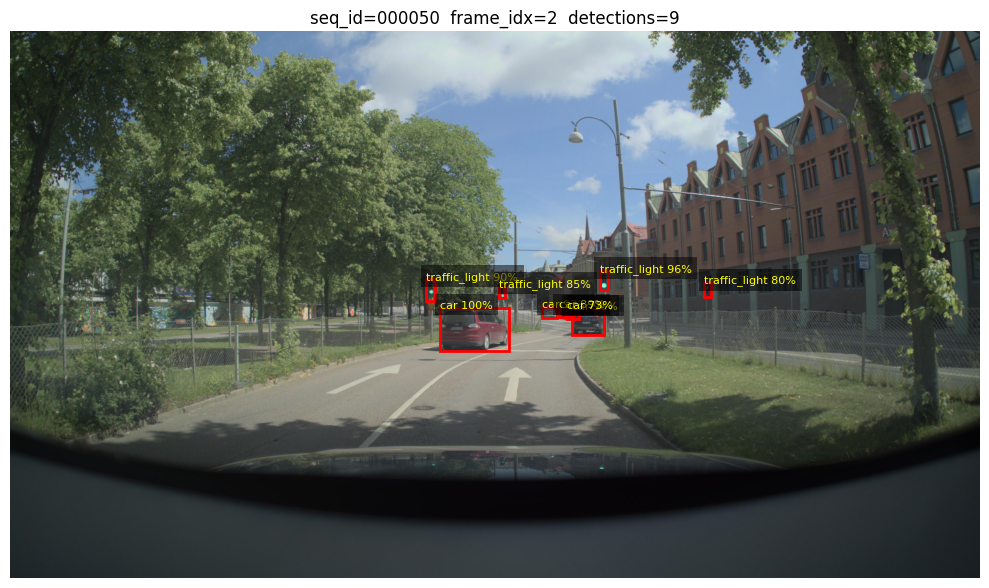

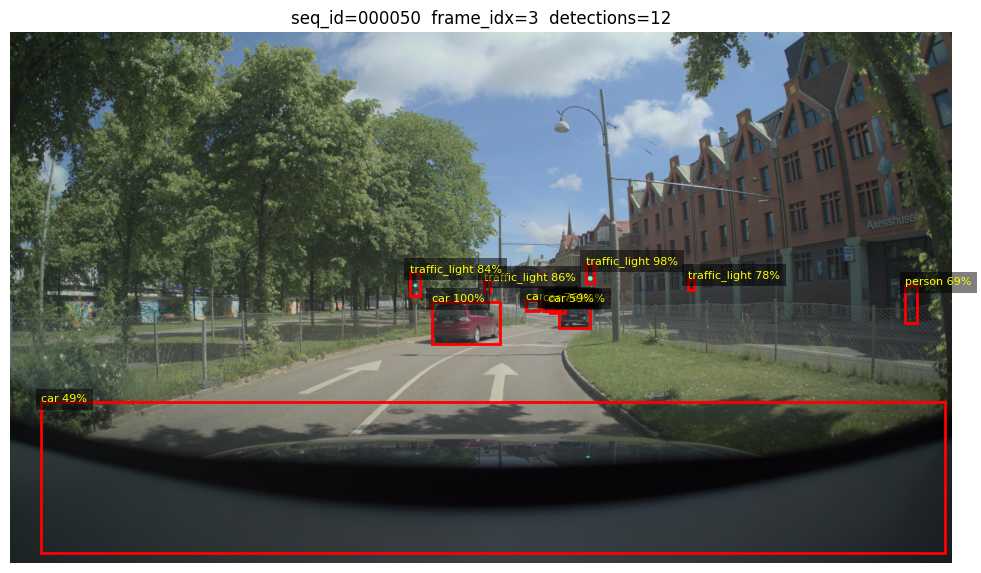

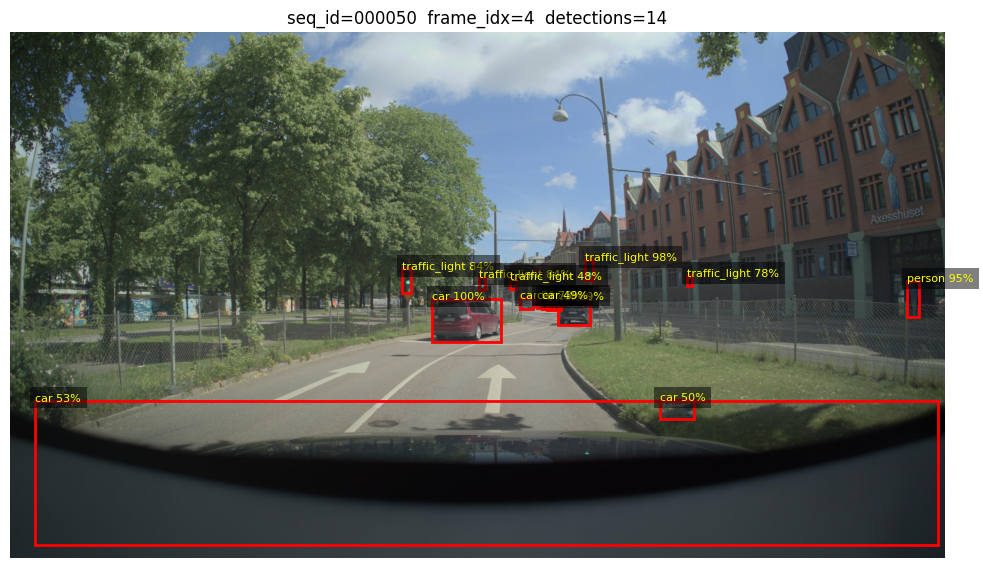

In [9]:
# =============================================================================
# Show multiple consecutive frames from the same sequence
# =============================================================================
# Adjust START_FRAME and NUM_FRAMES to walk through the sequence.
# Each frame is displayed with its bounding boxes (if any).
# NOTE: This cell reuses variables from Cell 1: sequence, images, anns_by_image,
#       seq_id, and CATEGORY_NAMES.

START_FRAME = 0   # first frame index to show
NUM_FRAMES = 5    # how many consecutive frames to display

# Reuse the ZodSequences frame list from cell 1
frames = sequence.info.get_camera_frames()

# Clamp end index to avoid IndexError if NUM_FRAMES exceeds available frames
end_frame = min(START_FRAME + NUM_FRAMES, len(frames))

for f_idx in range(START_FRAME, end_frame):
    # Find the image entry in the JSON that corresponds to this frame_idx
    matching = [img for img in images if img["frame_idx"] == f_idx]
    if not matching:
        print(f"frame_idx {f_idx}: not in annotation JSON (skipped during labeling?)")
        continue

    img_meta = matching[0]
    image_id = img_meta["id"]

    # Load pixel data via ZodSequences
    frame = frames[f_idx]
    img_np = frame.read()
    img = Image.fromarray(img_np)

    # Plot the frame
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)

    # Overlay bounding boxes for this frame
    for ann in anns_by_image.get(image_id, []):
        x, y, w, h = ann["bbox"]  # COCO format: top-left (x, y) + width, height
        rect = Rectangle((x, y), w, h, linewidth=2, edgecolor="red", facecolor="none")
        ax.add_patch(rect)

        # Label: "car 85%", "person 92%", etc.
        cat_id = ann.get("category_id", -1)
        score = float(ann.get("score", 0.0))
        cat_name = CATEGORY_NAMES.get(cat_id, str(cat_id))
        label = f"{cat_name} {score * 100:.0f}%"
        ax.text(
            x, y, label,
            color="yellow", fontsize=8,
            bbox=dict(facecolor="black", alpha=0.5, linewidth=0),
        )

    n_boxes = len(anns_by_image.get(image_id, []))
    ax.set_title(f"seq_id={seq_id}  frame_idx={f_idx}  detections={n_boxes}")
    ax.axis("off")
    plt.tight_layout()
    plt.show()